# Introduction

This notebook is aimed to help in post-processing Markov chain Monte Carlo outputs.

It implements basic steps of the MCMC chain analysis, that can be followd to understand
if the posterior sampling has gone well. In particular, this notebook is used to:

- understand chain convergence 
- compute statistical quantities of the chain
- plot basic results

We suggest to run the MCMC chains with burn_in=0 and thin=1, to 
have full control of the output. 

The notebook will read the output of the CosmoBolognaLib posterior sampling.

For a similar example, have a look at the emcee page: http://dfm.io/emcee/current/user/line/

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Run the CosmoBolognaLib ./fit example

In [2]:
#This is (of course) not mandatory. Here is done to have some example chain to plot.
os.system("./fit")

0

# Read the MCMC output

The basic inputs nedeed are the following:

- the chain file
- the directory where it is stored

In [3]:
inputDir = "../output/"
inputFilePar = "chains_linear_relation_parameters.dat"
inputFile = "chains_linear_relation_chain.dat"

Read all the columns of the table:

- the first column is the step number, the last three columns are the values of the log likelihood, the log prior and the log posterior

- all the other columns are the parameters, whose names are inferred from the header file 

- fixed parameters are identified as the ones with null standard deviation; there is currently no way 
  (and maybe there is no need) to recognize derived parameters

In [21]:
table = np.genfromtxt(inputDir+inputFile, unpack=True)

nPar = len(table)-4


In [33]:
ff = open(inputDir+inputFilePar, "r")

ff.readline()

isFree = [True]*nPar
nParEff = 0
names = [""]*(nPar+4)
names[0] = "Step"
names[-1] = "Log(Posterior)"
names[-2] = "Log(Prior)"
names[-3] = "Log(Likelihood)"
for i in range(nPar):
    ll = ff.readline()
    if "FREE" in ll:
        names[i+1] = ll[0:ll.index("FREE")]
        nParEff += 1
    if "FIXED" in ll:
        names[i+1] = ll[0:ll.index("FIXED")]
        isFree[i] = False

## Plot the chains

By plotting the chains you should be able to roughly identified the step
at which chains are converged. This should be used below as burn in.

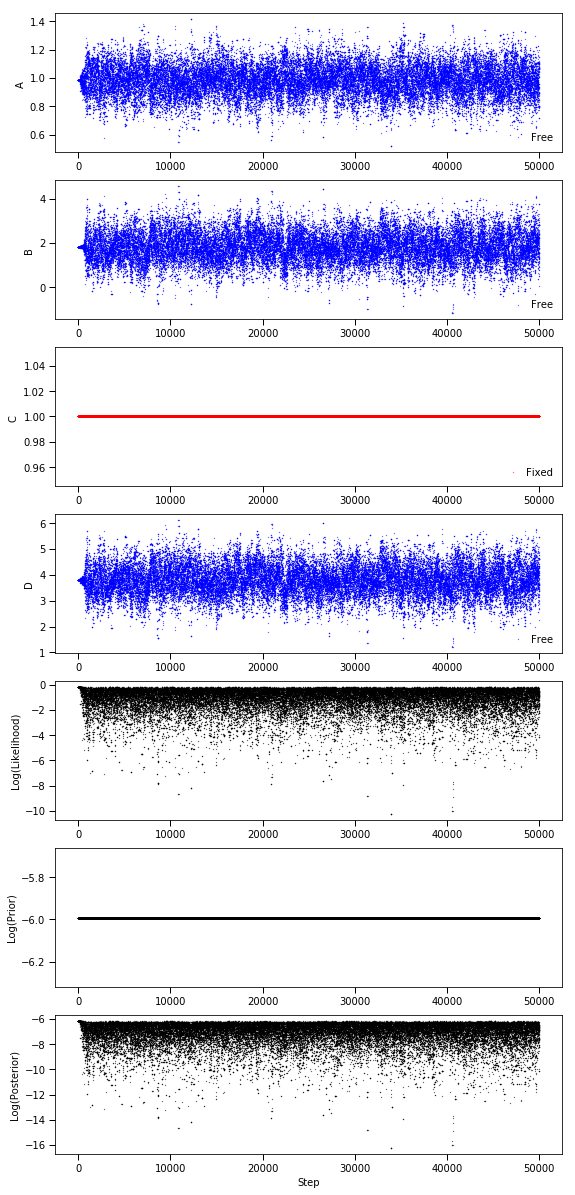

In [11]:
gs = gridspec.GridSpec(nPar+3, 2)

figure = plt.figure(figsize=(20, 3*(nPar+3)))

for i in range(nPar):
    ax = figure.add_subplot(gs[i, 0])
    label = "Free"
    color = "b"
    if (isFree[i]==False):
        label="Fixed"
        color = "r"
    ax.plot(table[0], table[i+1], '.k', ms=0.5, color=color, label=label)
    ax.set_ylabel(names[i+1])
    ax.legend(loc="lower right")

for i in range(nPar, nPar+3):
    ax = figure.add_subplot(gs[i, 0])
    ax.plot(table[0], table[i+1], '.k', ms=0.5)
    ax.set_ylabel(names[i+1])
    if (i==nPar+2):
        ax.set_xlabel("Step")


# Cut the chains

Here will be inserted some convergence criteria to choose automatically 
an appropriate value for the burn in.

In the meanwhile the value of the burn in should be changed manually.

The thin parameter should be changed as weel, if you only want to store and yield every "thin" samples in the chain.

In [16]:
#Here will be inserted some criteria to choose automatically 
#an appropriate value for the burn in, meanwhile...
burn_in = 2000
thin = 1

In [17]:
#cut the table
new_table = table[:,burn_in:-1:thin]
nPt = len(new_table[0])

# Fundamental quantities

The following is used to compute fundamental quantities to characterize parameter posterior distributions.

In [34]:
for i in range(nPar):
    print "\nParameter %s:"%names[i+1]
    tt = "Free"
    if not isFree[i]:
        print "Type: Fixed"
        print "Value = %s"%np.mean(new_table[i+1])
    else:
        print "Type: Free"
        print "Mean = %s"%np.mean(new_table[i+1])
        print "Std = %s"%np.std(new_table[i+1])
        print "Median = %s"%np.median(new_table[i+1])
        print "16-th percentile = %s"%np.percentile(new_table[i+1], 16)
        print "84-th percentile = %s"%np.percentile(new_table[i+1], 84)


Parameter A :
Type: Free
Mean = 0.985090784814
Std = 0.11138542555
Median = 0.9857118121
16-th percentile = 0.8749247553
84-th percentile = 1.094407974

Parameter B :
Type: Free
Mean = 1.81782532339
Std = 0.695473918296
Median = 1.802233032
16-th percentile = 1.14255840504
84-th percentile = 2.50964755472

Parameter C :
Type: Fixed
Value = 1.0

Parameter D :
Type: Free
Mean = 3.80291610821
Std = 0.598305120735
Median = 3.788878015
16-th percentile = 3.22190976316
84-th percentile = 4.400362545


# Corner plot

Print the corner plot of the MCMC results

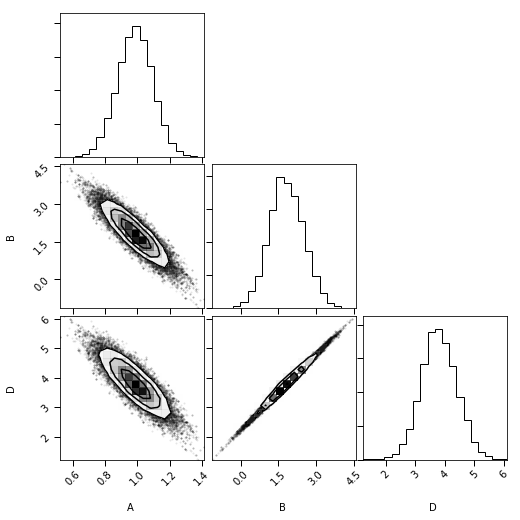

In [35]:
try:
    import corner
except ImportError:
    print "This piece of the notebook requires the corner.py package."
    print "Please install it if you are interested in producing corner plots"
    print "https://corner.readthedocs.io/en/latest/pages/custom.html"
    pass

#Create the corner plot.
#Disclaimer, for simplicity the fixed parameters are thrown away
samples = np.zeros(shape=(nParEff, nPt))
labels = [""]*nParEff

n = 0
for i in range(nPar):
    if isFree[i]:
        samples[n] = new_table[i+1]
        labels[n] = names[i+1]
        n += 1

figure = corner.corner(samples.T, labels=labels)